In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pca_embeddings = np.load('../embeddings/pca_embeddings.npy')
pca_embeddings.shape

scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(pca_embeddings)

def plot_clusters(labels, title):
    plt.scatter(scaled_embeddings[:, 0], scaled_embeddings[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

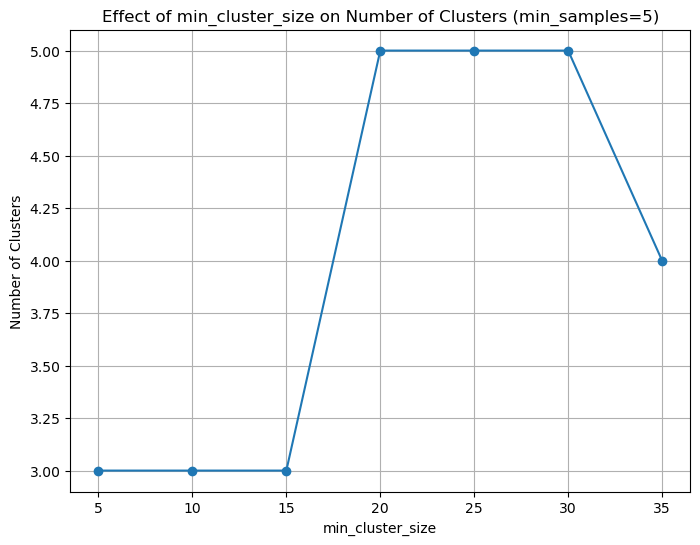

In [22]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt

# Define a range of values for min_cluster_size and min_samples
min_cluster_sizes = range(5, 40, 5)  # Example range for min_cluster_size
min_samples = 5  # Keep min_samples constant for this example

# Placeholder to store results
results = []

# Iterate through the range of min_cluster_size values
for min_cluster_size in min_cluster_sizes:
    hdbscan_cluster = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    cluster_labels_hdb = hdbscan_cluster.fit_predict(scaled_embeddings)
    
    # Calculate the number of clusters formed (excluding noise, labeled as -1)
    #num_clusters = len(set(cluster_labels_hdb)) - (1 if -1 in cluster_labels_hdb else 0)
    num_clusters = len(set(cluster_labels_hdb))
    results.append((min_cluster_size, num_clusters))

# Convert results to numpy array for easier plotting
results = np.array(results)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(results[:, 0], results[:, 1], marker='o')
plt.title(f'Effect of min_cluster_size on Number of Clusters (min_samples={min_samples})')
plt.xlabel('min_cluster_size')
plt.ylabel('Number of Clusters')
plt.grid()
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

def analyze_hdbscan_min_samples(scaled_embeddings, min_samples_range, min_cluster_size=20):
    """
    Analyze the effect of min_samples on the number of clusters formed by HDBSCAN.

    Parameters:
    - scaled_embeddings: np.ndarray, the scaled embeddings to cluster.
    - min_samples_range: range, the range of min_samples values to explore.
    - min_cluster_size: int, the min_cluster_size parameter for HDBSCAN (default is 20).

    Returns:
    - results: np.ndarray, the results containing min_samples and the corresponding number of clusters.
    """
    results = []

    # Iterate through the range of min_samples values
    for min_samples in min_samples_range:
        hdbscan_cluster = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
        cluster_labels_hdb = hdbscan_cluster.fit_predict(scaled_embeddings)

        # Calculate the number of clusters formed (excluding noise, labeled as -1)
        num_clusters = len(set(cluster_labels_hdb)) - (1 if -1 in cluster_labels_hdb else 0)
        results.append((min_samples, num_clusters))

    # Convert results to numpy array for easier plotting
    results = np.array(results)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(results[:, 0], results[:, 1], marker='o')
    plt.title(f'Effect of min_samples on Number of Clusters (min_cluster_size={min_cluster_size})')
    plt.xlabel('min_samples')
    plt.ylabel('Number of Clusters')
    plt.grid()
    plt.show()

    return results

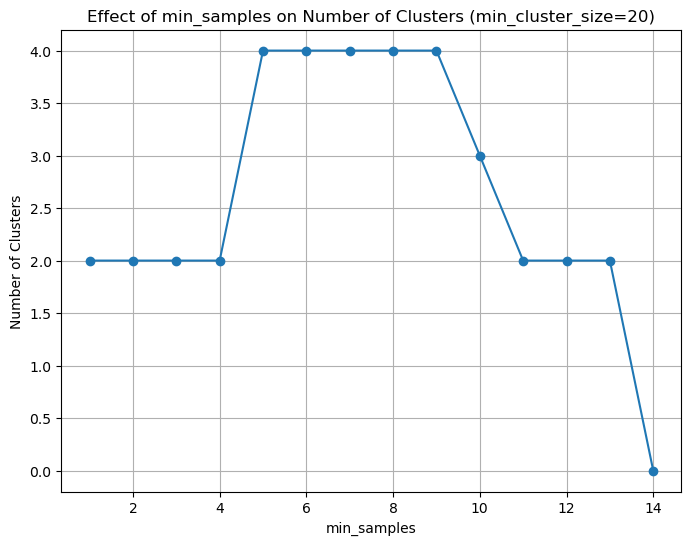

In [10]:
# Assuming scaled_embeddings is already defined
min_samples_range = range(1, 15)  # Example range for min_samples
min_cluster_size = 20  # Keep min_cluster_size constant for this example

# Call the function to analyze the effect of min_samples
results = analyze_hdbscan_min_samples(scaled_embeddings, min_samples_range, min_cluster_size)

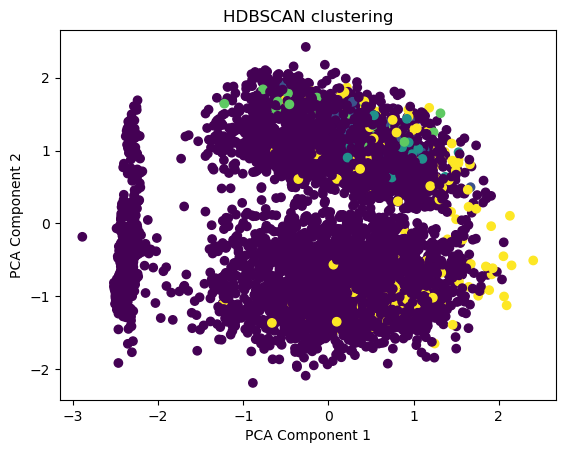

In [24]:
import hdbscan

hdbscan_cluster = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=30)
cluster_labels_hdb = hdbscan_cluster.fit_predict(scaled_embeddings)
plot_clusters(cluster_labels_hdb, 'HDBSCAN clustering')
np.save('cluster_labels_hdb.npy', cluster_labels_hdb)


In [ ]:
import numpy as np

unique, counts = np.unique(cluster_labels_hdb, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(cluster_counts)


In [ ]:
import pandas as pd
# Filter the noise points (label -1)
noise_points = scaled_embeddings[cluster_labels_hdb == -1]

plt.scatter(noise_points[:, 0], noise_points[:, 1], c='purple', label='Noise')
plt.title('Noise Points')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Save the indices of noise points
noise_indices = np.where(cluster_labels_hdb == -1)[0]

abstracts = pd.read_csv('data/arxiv_abstracts.csv')
# Assuming `abstracts` is the DataFrame containing the original abstracts
noise_abstracts = abstracts.iloc[noise_indices]
print(noise_abstracts)

# Save the noise abstracts to a CSV file
noise_abstracts.to_csv('data/noise_abstracts.csv', index=False)
print("Saved noise abstracts to noise_abstracts.csv")


In [ ]:
import pandas as pd

noise_points = scaled_embeddings[cluster_labels_hdb == -1]
non_noise_points = pca_embeddings[cluster_labels_hdb != -1]
print(f"Number of noise points: {len(noise_points)}")
print(f"Number of non-noise points: {len(non_noise_points)}")


In [ ]:
abstracts['Cluster'] = cluster_labels_hdb

# Filter out noise points (-1) and group by cluster
clusters = abstracts[abstracts['Cluster'] != -1].groupby('Cluster')

# Iterate through each cluster and save abstracts
for cluster_id, cluster_data in clusters:
    # Save abstracts belonging to this cluster
    cluster_filename = f'cluster_{cluster_id}_abstracts.csv'
    cluster_data.to_csv(cluster_filename, index=False)
    print(f"Saved Cluster {cluster_id} abstracts to {cluster_filename}")

# Optionally, save a single file with all clusters grouped
abstracts.to_csv('../data/all_clusters_abstracts.csv', index=False)
print("Saved all cluster abstracts to all_clusters_abstracts.csv")
